In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore")

# Load dataset

In [3]:
activity_df = pd.read_csv("../data/training_data_subset.csv", delimiter=";")
activity_df = activity_df.drop(columns=["CompoundID"])
activity_df.dropna(subset=["Label"], inplace=True)
activity_df.head()

,Label,Hf_Hf_d1,Hf_Hf_d2,Hf_Hf_d3,Hf_Hf_d4,Hf_Hf_d5,Hf_Hf_d6,Hf_Hf_d7,Hf_Hf_d8,Hf_Hf_d9,...,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3
0,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,0,1,0,0,1,0,0,0.272727
1,active,0.0,0.0,0.3,1.3,0.3,0.0,0.0,0.0,0.0,...,1,2,2,0,0,0,1,2,2,0.600000
2,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,1,0,0,2,0,0,0.250000
3,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,1,1,0,1,1,0,0,0.285714
4,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,0,0,0,0,2,0,0,0.333333


In [4]:
X = activity_df[activity_df.columns.difference(["Label"])]
y = activity_df["Label"]

# Load model

In [5]:
model_location = "../models/final_model_PLD_XGBoost.pkl"
with open(model_location, "rb") as f:
    pld_model = pickle.load(f)

# Inspecting important features

In [6]:
os.makedirs("../figures", exist_ok=True)

In [7]:
importance = pld_model.feature_importances_
feature_importance = pd.DataFrame({"feature": X.columns, "importance": importance})

feature_importance = feature_importance.sort_values("importance", ascending=False).head(
    10
)
feature_importance

,feature,importance
103,Ar_+_d7,0.099141
102,Ar_+_d6,0.098700
43,+_Ac_d8,0.026601
198,D_Ac_d11,0.024447
8,+_+_d3,0.023015
100,Ar_+_d4,0.021562
293,Hf_D_d14,0.020573
170,D_+_d13,0.018776
101,Ar_+_d5,0.018761
77,Ac_Ac_d10,0.014467


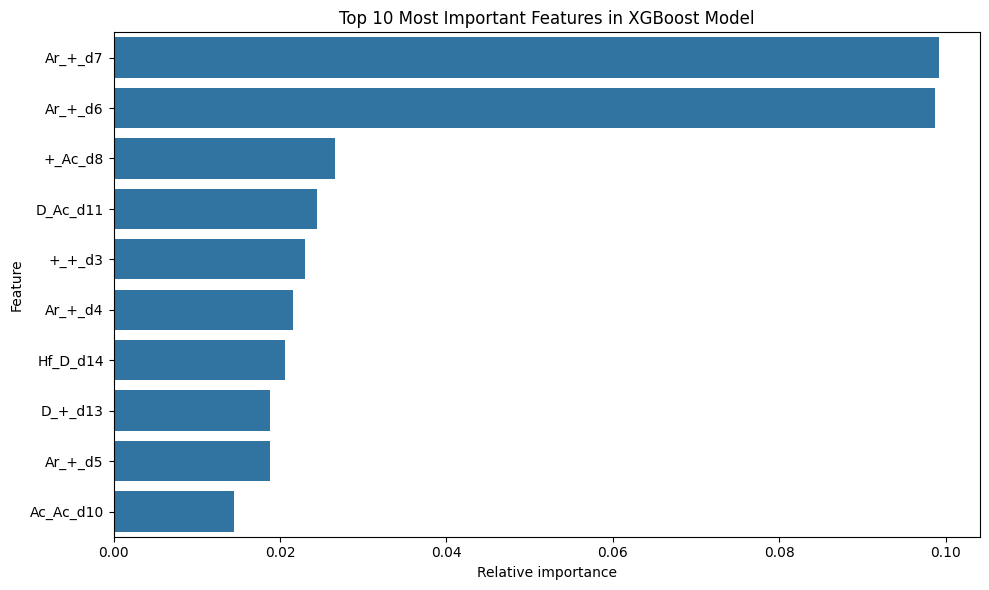

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Top 10 Most Important Features in XGBoost Model")
plt.xlabel("Relative importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("../figures/feature_importance.png", dpi=400)
plt.show()

# Feature inspection

In [9]:
top10cols = feature_importance["feature"].values

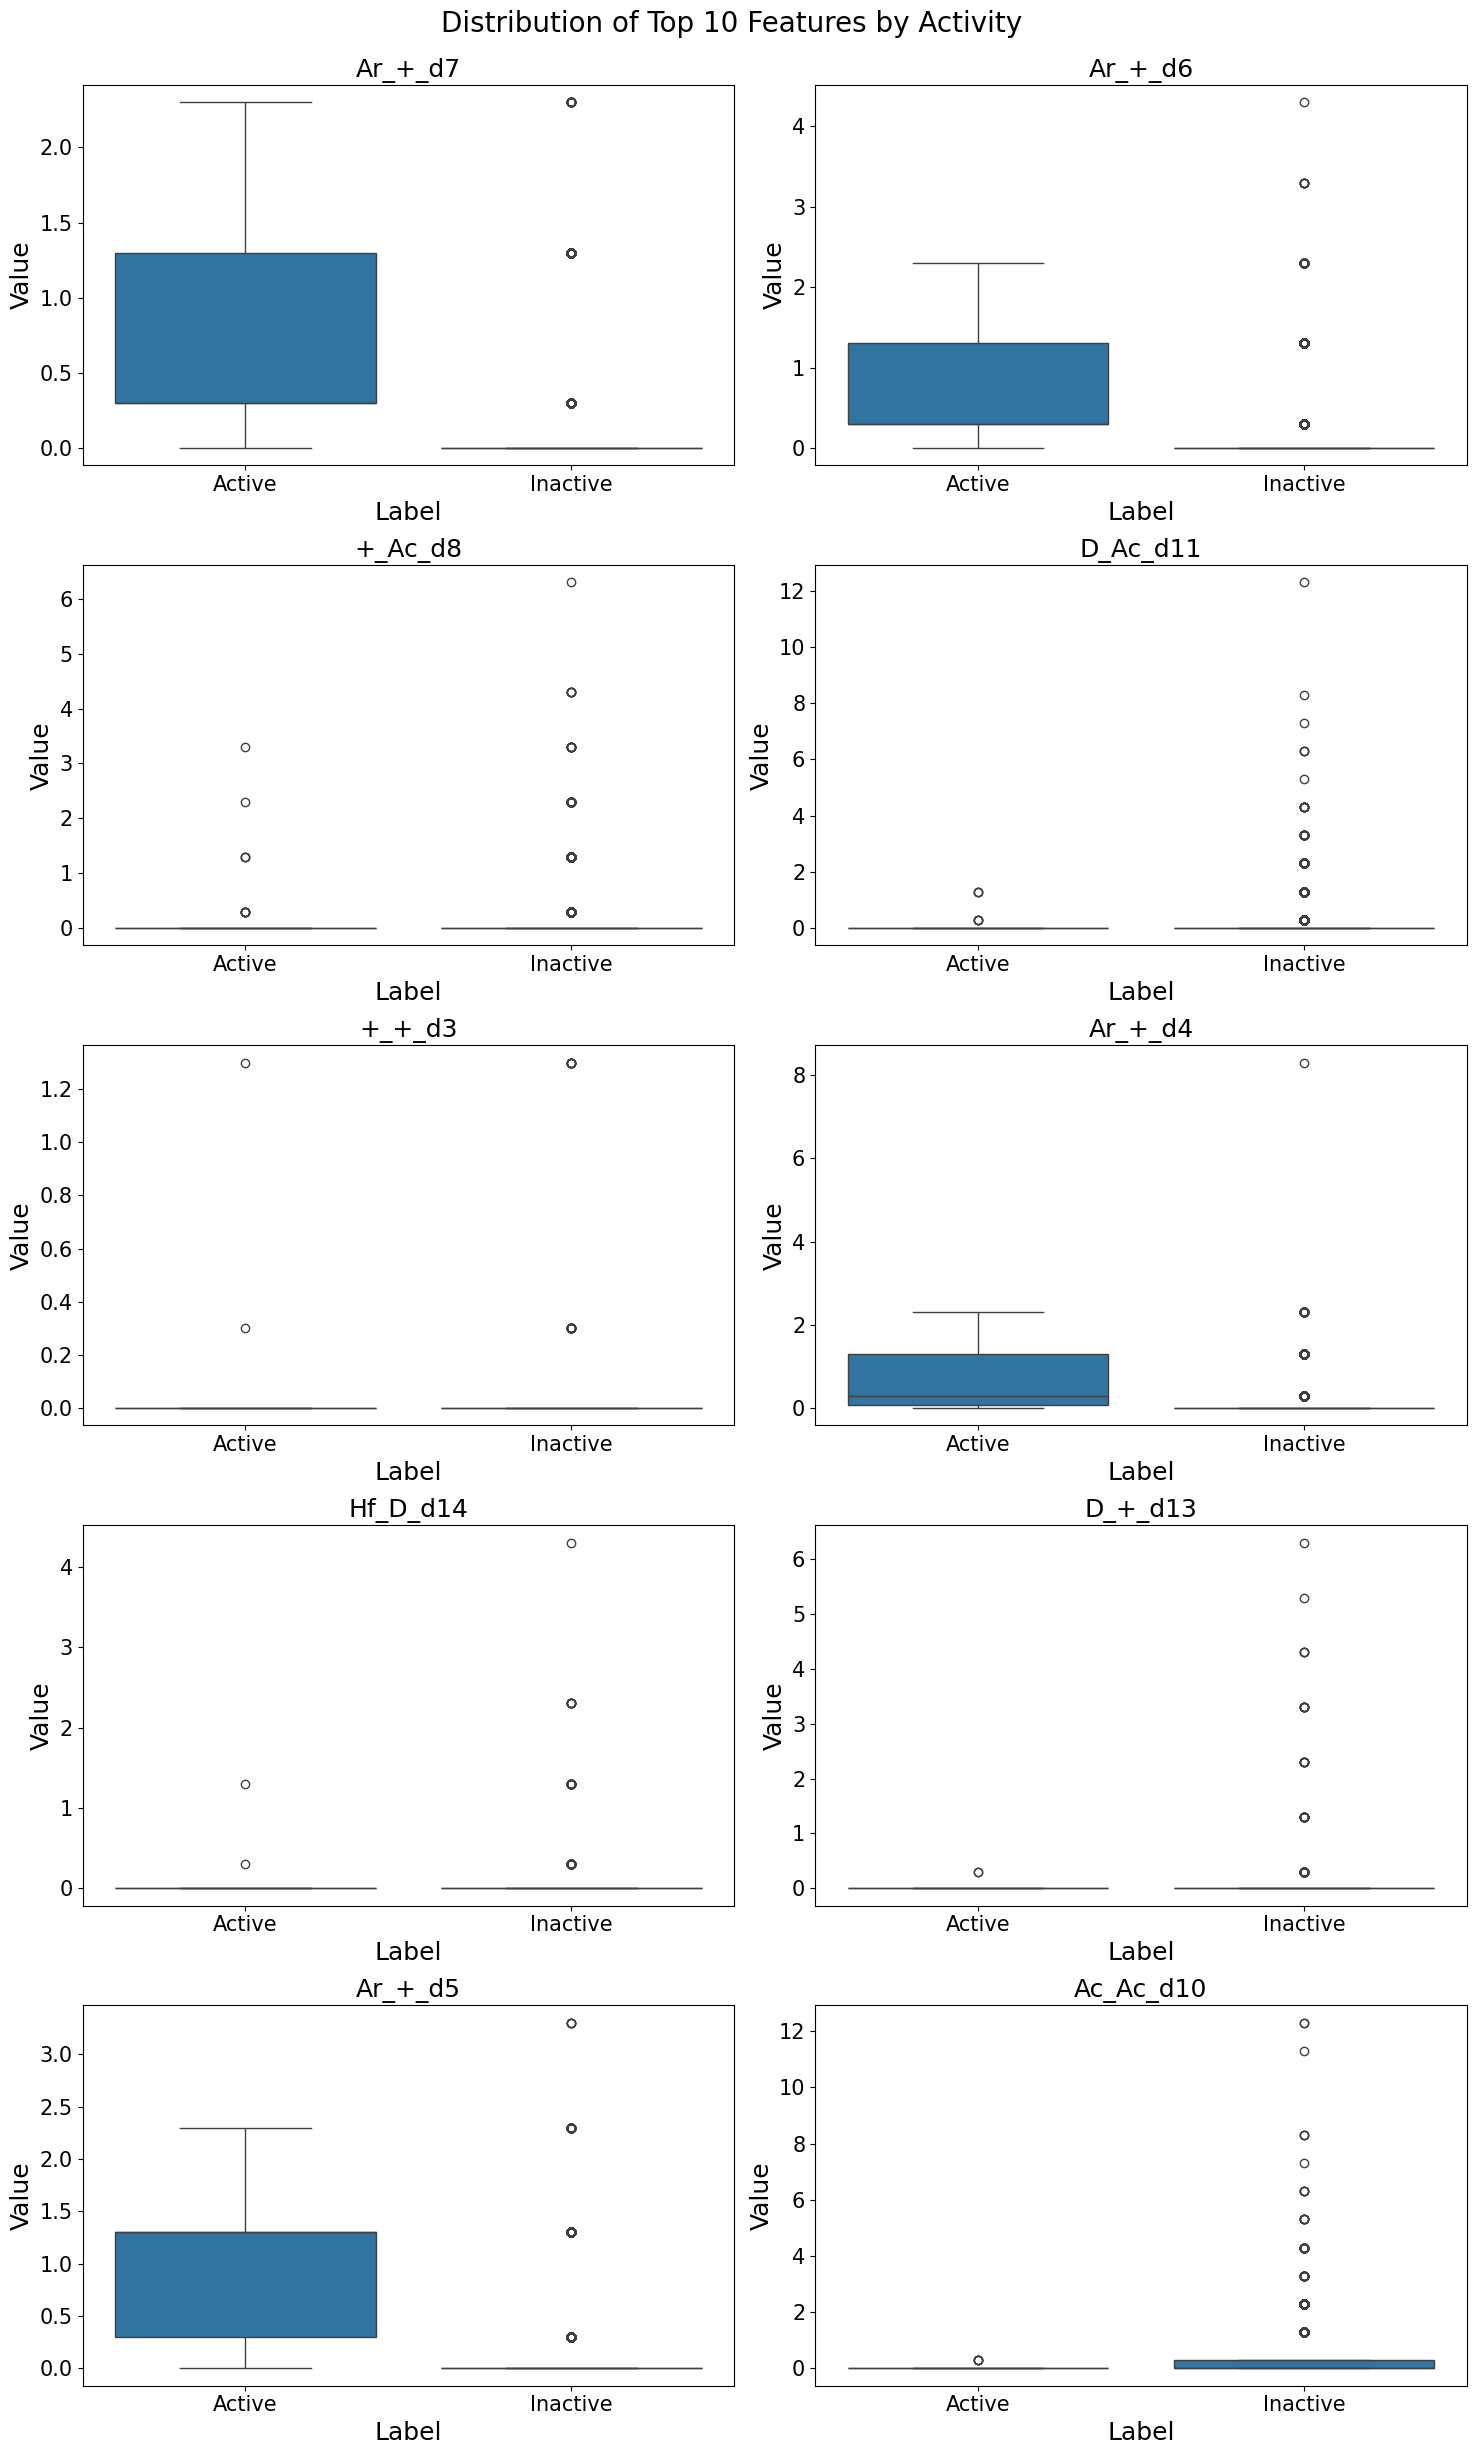

In [10]:
# Set up the plot
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle("Distribution of Top 10 Features by Activity", fontsize=20)

# Flatten the axes array for easier iteration
axes = axes.flatten()

activity_df = activity_df.sort_values("Label")
activity_df["Label"] = activity_df["Label"].str.capitalize()

# Create a boxplot for each feature
for i, col in enumerate(top10cols):
    sns.boxplot(x="Label", y=col, data=activity_df, ax=axes[i])
    axes[i].set_title(col, fontsize=18)
    axes[i].set_xlabel("Label", fontsize=18)
    axes[i].set_ylabel("Value", fontsize=18)
    axes[i].tick_params(axis="both", which="major", labelsize=15)

# Adjust layout and display the plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Save the figure as SVG
plt.savefig(
    "../figures/top10_features_boxplots.svg", format="svg", dpi=600, bbox_inches="tight"
)

plt.show()

In [11]:
def clean_and_convert(series):
    return pd.to_numeric(
        series.replace({"": np.nan, " ": np.nan}, regex=True), errors="coerce"
    )


def add_significance(ax, data, feature, class_col="Label"):
    classes = data[class_col].unique()

    try:
        group1 = data[data[class_col] == classes[0]][feature].dropna()
        group2 = data[data[class_col] == classes[1]][feature].dropna()

        if len(group1) > 0 and len(group2) > 0:
            stat, p = stats.mannwhitneyu(group1, group2)

            # Add significance indicator
            if p < 0.001:
                text = f"p < 0.001 ***"
            elif p < 0.01:
                text = f"p < 0.01 **"
            elif p < 0.05:
                text = f"p < 0.05 *"
            else:
                text = f"p = {p:.3f} ns"

            # Add text to the plot with smaller font size and adjusted position
            ax.text(
                0.5,
                0.95,
                text,
                ha="center",
                va="top",
                transform=ax.transAxes,
                fontsize=12,
            )
    except Exception as e:
        print(f"Error in add_significance for {feature}: {str(e)}")

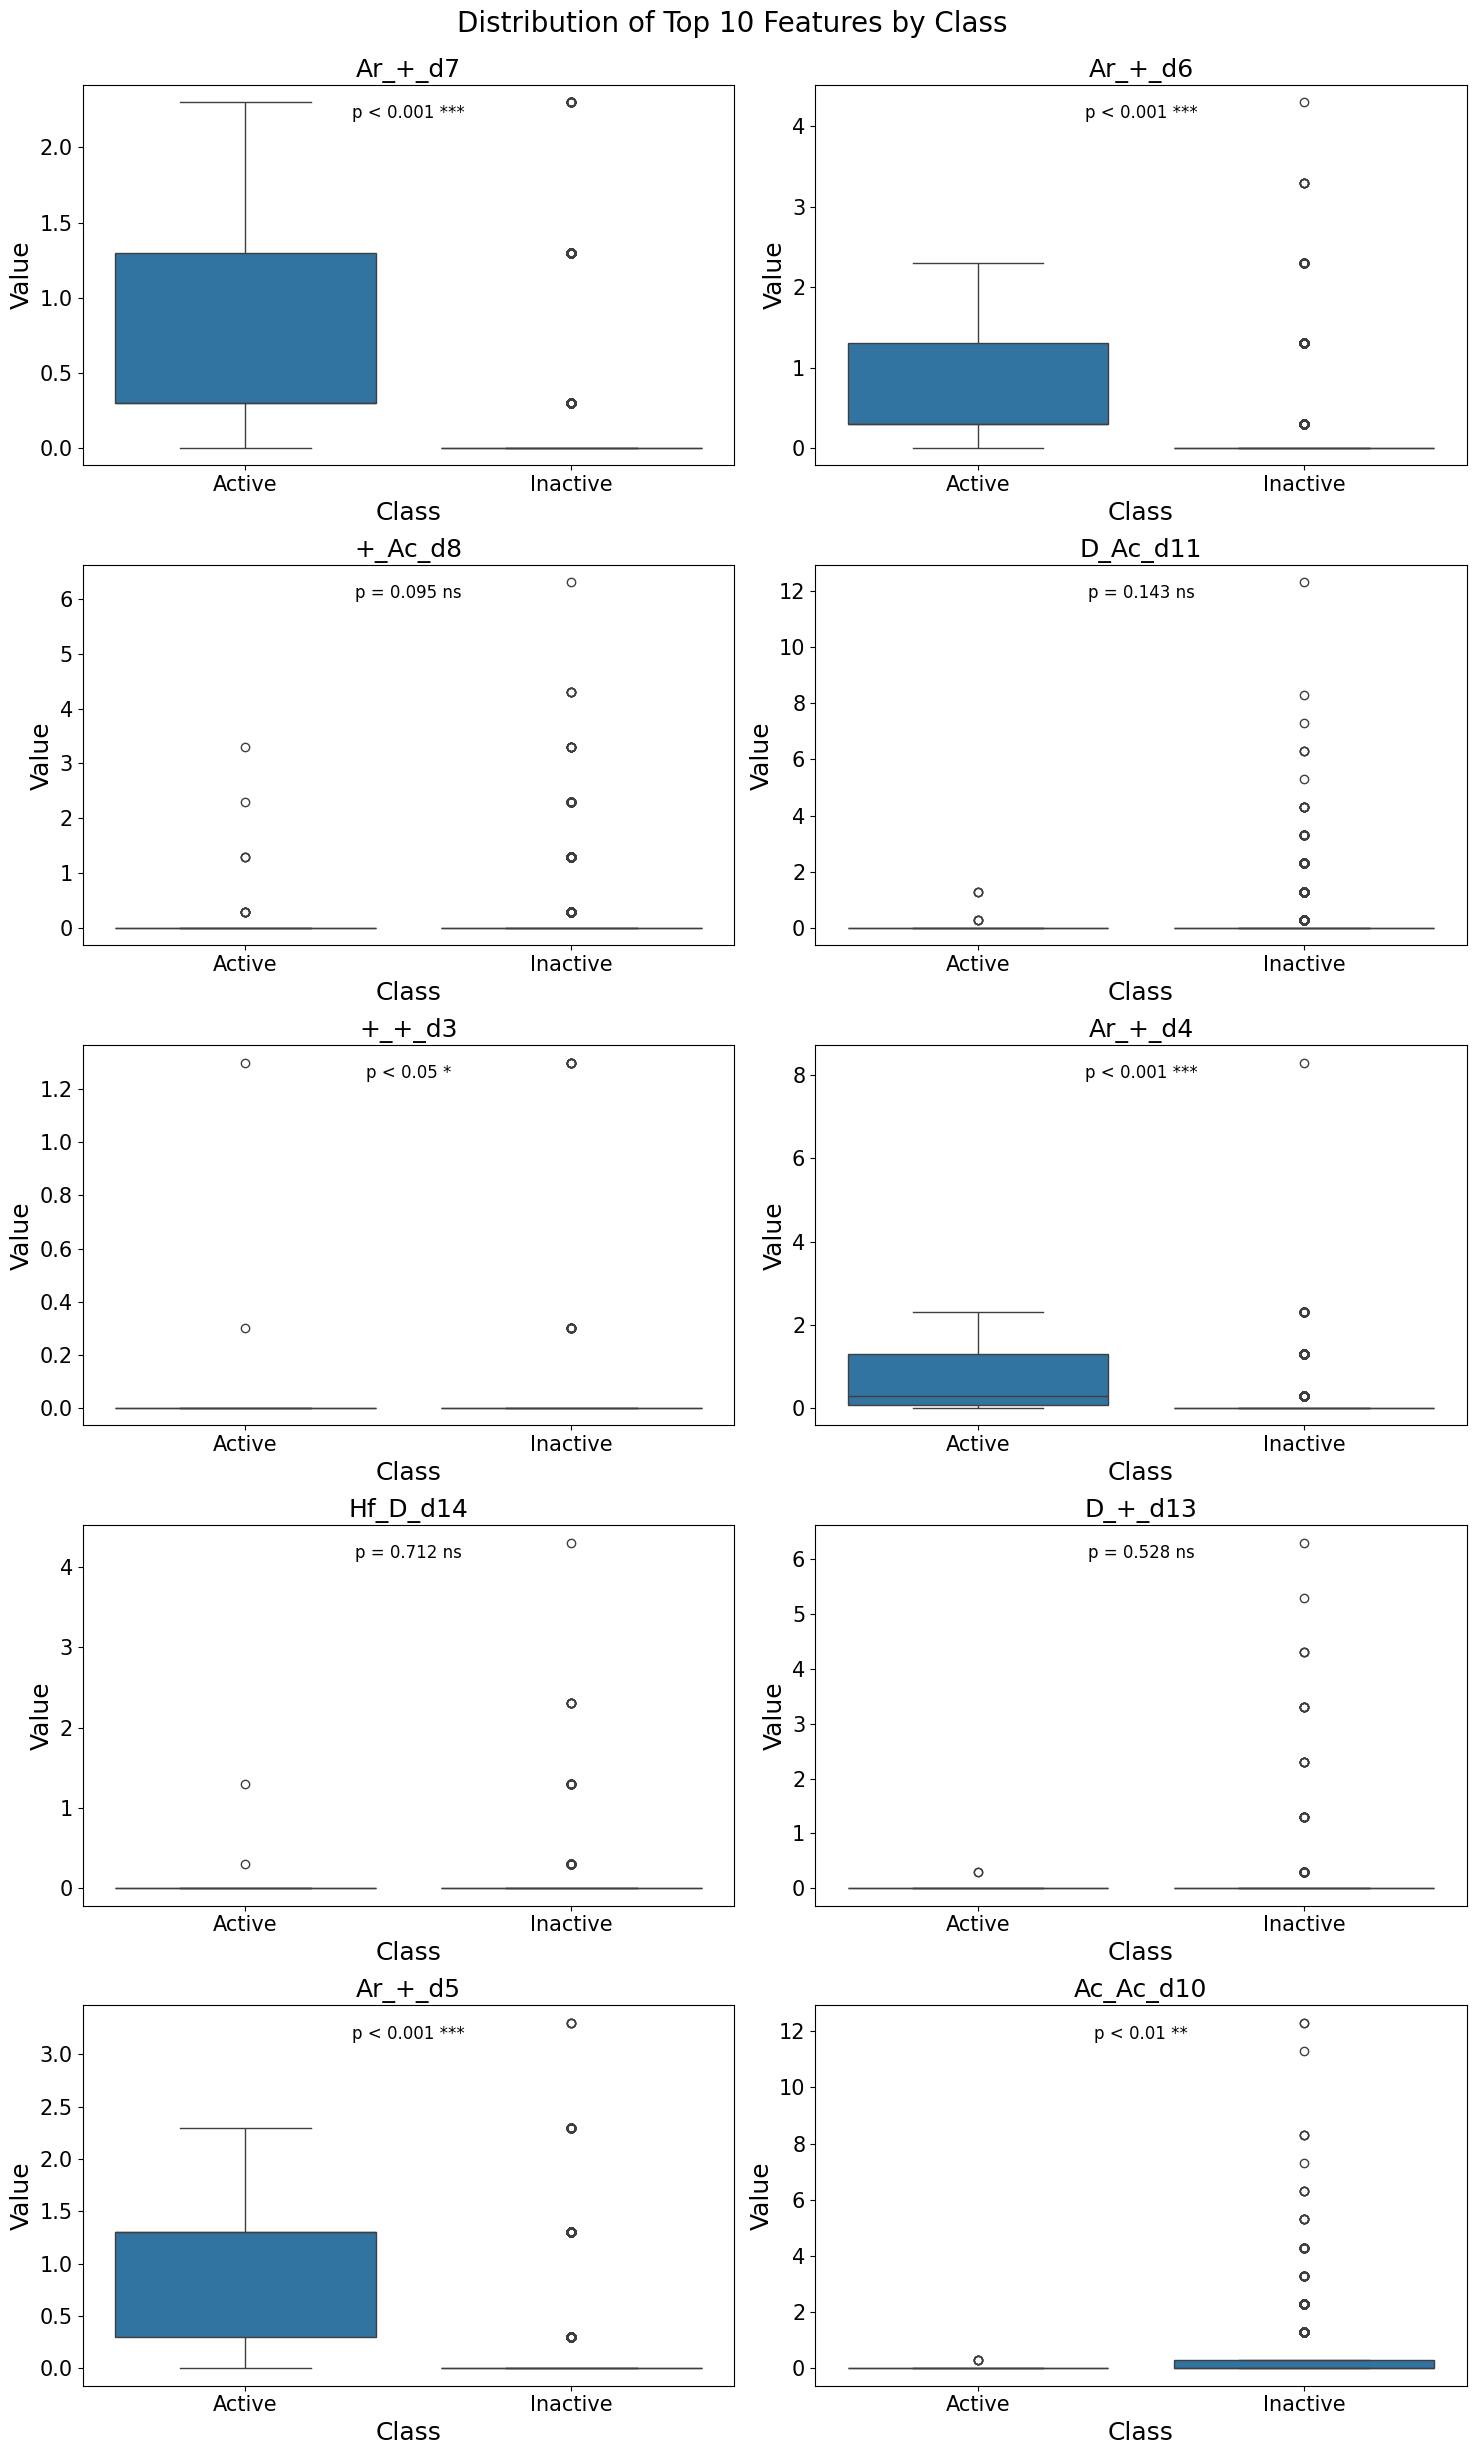

In [ ]:
# Set up the plot with increased spacing between subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle("Distribution of Top 10 Features by Class", fontsize=20)
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Increase spacing between subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

activity_df = activity_df.sort_values("Label")
activity_df["Label"] = activity_df["Label"].str.capitalize()

# Create a boxplot for each feature
for i, col in enumerate(top10cols):
    try:
        sns.boxplot(x="Label", y=col, data=activity_df, ax=axes[i])
        axes[i].set_title(col, fontsize=18)
        axes[i].set_xlabel("Class", fontsize=18)
        axes[i].set_ylabel("Value", fontsize=18)
        axes[i].tick_params(axis="both", which="major", labelsize=15)

        # Add significance indicators
        add_significance(axes[i], activity_df, col)
    except Exception as e:
        print(f"Error plotting {col}: {str(e)}")
        axes[i].text(0.5, 0.5, f"Error plotting {col}", ha="center", va="center")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Save the figure as SVG
plt.savefig(
    "../figures/top10_features_boxplots_with_significance.svg",
    format="svg",
    dpi=600,
    bbox_inches="tight",
)